In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error

# Data preprocessing

In [3]:
import yfinance as yf

aapl = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
aapl = aapl['Close']
aapl.head(10)

[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2015-01-02,24.261047
2015-01-05,23.577572
2015-01-06,23.579796
2015-01-07,23.910433
2015-01-08,24.829126
2015-01-09,24.855757
2015-01-12,24.243290
2015-01-13,24.458544
2015-01-14,24.365345


In [4]:
df = aapl
df.head()

Ticker,AAPL
Date,
2015-01-02,24.261047
2015-01-05,23.577572
2015-01-06,23.579796
2015-01-07,23.910433
2015-01-08,24.829126


In [5]:
df.tail()

Ticker,AAPL
Date,
2024-12-23,254.367035
2024-12-24,257.286682
2024-12-26,258.103729
2024-12-27,254.685883
2024-12-30,251.307877


In [6]:
df = df.fillna(method = 'ffill')
df.tail(10)

Ticker,AAPL
Date,
2024-12-16,250.151962
2024-12-17,252.583344
2024-12-18,247.172562
2024-12-19,248.906403
2024-12-20,253.589798
2024-12-23,254.367035
2024-12-24,257.286682
2024-12-26,258.103729
2024-12-27,254.685883


In [7]:
df['LogAAPL']= np.log(df['AAPL'])
df

Ticker,AAPL,LogAAPL
Date,,
2015-01-02,24.261047,3.188872
2015-01-05,23.577572,3.160296
2015-01-06,23.579796,3.160390
2015-01-07,23.910433,3.174315
2015-01-08,24.829126,3.212017
...,...,...
2024-12-23,254.367035,5.538778
2024-12-24,257.286682,5.550191
2024-12-26,258.103729,5.553362


In [8]:
df2 = df.copy()
df2.shape

(2515, 2)

In [9]:
test_period = int(len(df) * 0.2)
train_period = len(df) - test_period

print("train_period:", train_period)
print("test_period:", test_period)

train_period: 2012
test_period: 503


In [10]:
train = df.iloc[:train_period]
test  = df.iloc[train_period:]

In [11]:
series = df['LogAAPL'].dropna().to_numpy()

Tx = 60 # using the past observations to forecast the next one.
Ty = 1 # forecasting only one step ahead
X = np.array([series[t:t+Tx] for t in range(len(series) - Tx-Ty+1)]).reshape(-1, Tx, 1)
Y = np.array([series[t+Tx+Ty-1] for t in range(len(series) - Tx-Ty+1)]).reshape(-1, Ty)
N = len(X)

print("X:", X.shape, "Y:", Y.shape, "N:", N)

X: (2455, 60, 1) Y: (2455, 1) N: 2455


In [12]:
Xtrain, Ytrain = X[:-test_period], Y[:-test_period]
Xtest, Ytest = X[-test_period:], Y[-test_period:]

In [13]:
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((1952, 60, 1), (1952, 1), (503, 60, 1), (503, 1))

# One-step Forecast

Model Training

In [ ]:
n_features = 1 
inputs = keras.Input(shape=(Tx, n_features))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_aapl_forecast_60d.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(Xtrain, Ytrain,
                    epochs=100,
                    validation_data=(Xtest,Ytest),
                    callbacks=callbacks)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.8765 - mae: 1.4640 - val_loss: 0.5857 - val_mae: 0.7541
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0285 - mae: 0.1296 - val_loss: 0.0463 - val_mae: 0.1888
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0152 - mae: 0.0971 - val_loss: 0.0246 - val_mae: 0.1263
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0133 - mae: 0.0949 - val_loss: 0.0170 - val_mae: 0.0995
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0122 - mae: 0.0935 - val_loss: 0.0315 - val_mae: 0.1540
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0107 - mae: 0.0903 - val_loss: 0.0860 - val_mae: 0.2828
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0103 - mae: 0.0848 - val_loss: 0.0194 - val_mae: 0.1110
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0091 - mae: 0.0781 - val_loss: 0.0090 - val_mae: 0.0760
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - lo

In [14]:
model = tf.keras.models.load_model('lstm_aapl_forecast_60d.keras')

In [15]:
train_predictions = model.predict(Xtrain)
test_predictions = model.predict(Xtest)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [16]:
train_indicator = (df.index <= train.index[-1])
test_indicator =  (df.index > train.index[-1])

train_indicator[:Tx] = False

df.loc[train_indicator, '1step_train'] =  train_predictions
df.loc[test_indicator, '1step_test'] =  test_predictions

df['1step_train_orig'] = np.exp(df['1step_train'])
df['1step_test_orig'] = np.exp(df['1step_test'])

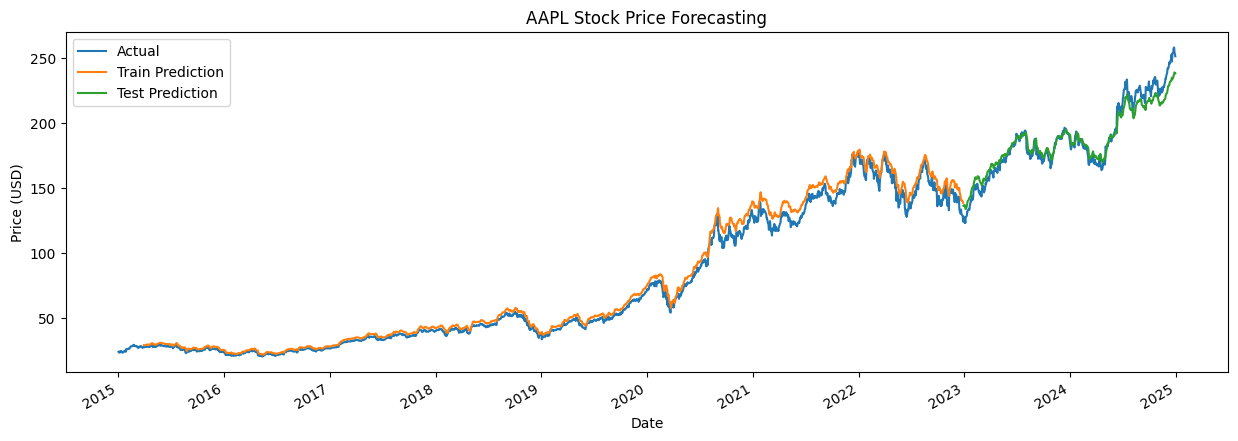

In [17]:
df_plot = df[['AAPL', '1step_train_orig', '1step_test_orig']].plot(figsize=(15, 5))
df_plot.set_title('AAPL Stock Price Forecasting')
df_plot.set_xlabel('Date')
df_plot.set_ylabel('Price (USD)')
df_plot.legend(['Actual', 'Train Prediction', 'Test Prediction'])

plt.show()

# Multi-Step

Using the same model

In [18]:
multistep_predictions = []

# first test input
last_x = Xtest[0]

# Start a loop that will continue until we have the desired number of future forecasts (test_period).
while len(multistep_predictions) < test_period:
  prediction = model.predict(last_x.reshape(1, -1, 1))[0]
  
  # update the predictions list
  multistep_predictions.append(prediction)

  # update the new input
  # The last_x array, which serves as input for the next prediction, is updated. The np.roll(last_x, -1) shifts all elements of last_x one position to the left. 
  # The last element of last_x, which is now freed up, is filled with the last prediction p.
  last_x = np.roll(last_x, -1)
  last_x[-1] = prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

In [ ]:
df.loc[test_indicator, 'multistep_test'] = multistep_predictions
df['multistep_test_orig'] = np.exp(df['multistep_test'])

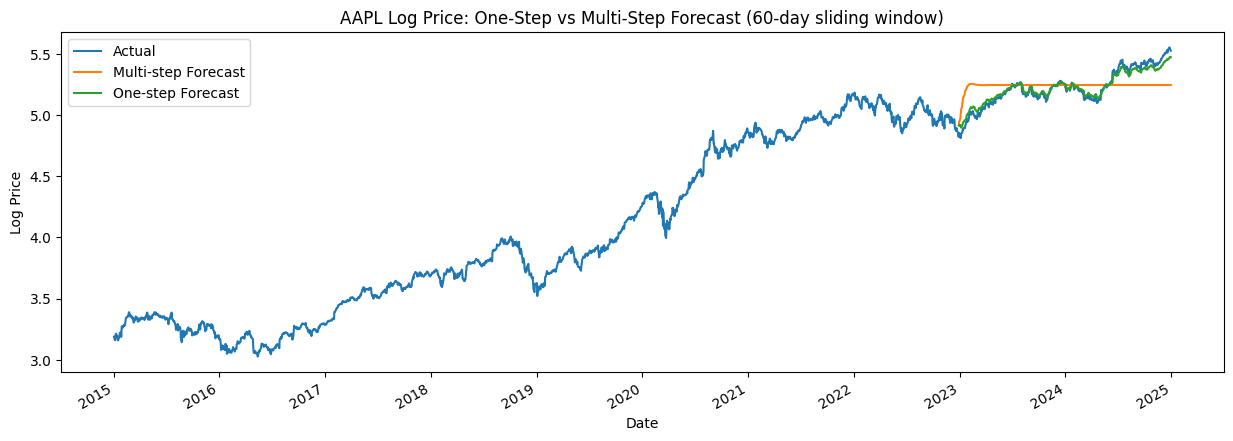

In [45]:
df_plot_both = df[['LogAAPL', 'multistep_test', '1step_test']].plot(figsize=(15, 5))
df_plot_both.set_title('AAPL Log Price: One-Step vs Multi-Step Forecast (60-day sliding window)')
df_plot_both.set_xlabel('Date')
df_plot_both.set_ylabel('Log Price')
df_plot_both.legend(['Actual', 'Multi-step Forecast', 'One-step Forecast'])

plt.show()

# Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error

print("MSE (one-step):", mean_squared_error(Ytest, test_predictions))
print("MAE (one-step):", mean_absolute_error(Ytest, test_predictions))

print()

print("MSE (multi-step):", mean_squared_error(Ytest, multistep_predictions))
print("MAE (multi-step):", mean_absolute_error(Ytest, multistep_predictions))

MSE (one-step): 0.0012219515462817865
MAE (one-step): 0.02798777117673169

MSE (multi-step): 0.020072761478817116
MAE (multi-step): 0.11610966753468882
